#  方向微分によるニューラルネットワークの勾配近似
この記事では([Silver, et al., "Learning by Directional Gradient Descent." ICLR. 2021](https://openreview.net/forum?id=5i7lJLuhTm))および([Baydin, et al., "Gradients without Backpropagation", arXiv, 2022](http://arxiv.org/abs/2202.08587))の解説&実装を行います．

両者とも**摂動 (perturbation)** と**方向微分(directional gradient)** を用いて勾配を近似することで，誤差逆伝播法 (backpropagation)を用いずにニューラルネットワークを訓練するという手法を提案しています．gradient-free optimizationの一種とも言えるでしょう．以後，Silverらの提案手法を**DODGE**(Deep Online Directional Gradient Estimate), Baydinらの提案手法を**FGD** (Forward gradient descent)と呼ぶことにします．

この手法の利点としては近似勾配の計算にニューラルネットワークの順伝播のみしか用いないため，パラメータを並列に更新することができる，ということが挙げられます．Baydinらは脳(神経回路網)の学習則にも触れていますが，biologicalなモデルに落とし込むとすれば次のように解釈できると思います：

各シナプスにおいてランダムかつ微小なシナプス伝達強度の変化 (e.g. spine headの大きさ変化) の方向を"記憶"しておき，損失の方向微分の値というglobal factorを各シナプスにfeedbackした上で"記憶"しておいた微小なシナプス伝達強度変化に乗じて再度シナプス伝達強度を大きく変化させる． 

ただし，これはあくまで解釈です．この機構が実現可能かどうかの議論はこの記事ではしないことにします．

## 下準備1: 摂動による学習法
やや外れた話題ですが，先に**摂動 (perturbation)** による勾配を使用しない単純な学習法を紹介しておきます．ニューラルネットワークのパラメータを$\boldsymbol{\theta} \in \mathbb{R}^p$, データサンプルを$\mathbf{x}$，損失関数を$L(\boldsymbol{\theta}, \mathbf{x})$とします．また，パラメータへの摂動を$\mathbf{v}\in \mathbb{R}^p$とします．ここで単純な学習法とは，「パラメータに摂動を加えて損失が下がったらそのパラメータに更新する」です．

$$
\begin{align*}
&\Delta L = L(\boldsymbol{\theta}+\mathbf{v}, \mathbf{x}) - L(\boldsymbol{\theta}, \mathbf{x})\\
&\textbf{if}\ \Delta L < 0\ \text{:}\\
&\quad \boldsymbol{\theta} \leftarrow \boldsymbol{\theta}+\mathbf{v}
\end{align*}
$$

一応学習は進みますが，効率的ではありません．誤差逆伝播法を用いない学習法の研究においてベースラインとしてよく用いられます．

## 下準備2: 方向微分とJacobian-vector productの計算
本記事で紹介する学習則では**方向微分(directional gradient)** というものが用いられます．関数$f$について点$\mathbf{u}$における方向$\mathbf{v}$の方向微分は

$$
\nabla_\mathbf{v}f(\mathbf{u})= \lim_{h\to 0} \frac{f(\mathbf{u}+h\mathbf{v}) - f(\mathbf{u})}{h}
$$

として定義されます．また$f$が点$\mathbf{u}$において微分可能なら

$$
\nabla_\mathbf{v}f(\mathbf{u})=\nabla f(\mathbf{u})\cdot \mathbf{v}
$$

が成り立ちます．ここで右辺を**Jacobian-vector product** (JVP) と呼びます．JVPを計算する上でSilverらはForward Mode ADで計算できる[`jax.jvp`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jvp.html#jax.jvp)を用いています．BaydinらはPytorch実装かつ自動微分部分は自前実装したようです．Pytorchにも[`torch.autograd.functional.jvp`](https://pytorch.org/docs/stable/generated/torch.autograd.functional.jvp.html)がありますが，"double backwards trick"というbackwardsを2回用いる手法を用いているので勾配が必要になります．

妥協案として有限差分(finite difference)を用いてJacobian-vector productを近似計算します ($\epsilon$は小さい値です)．

$$
\nabla f(\mathbf{u})\cdot \mathbf{v} \approx \frac{f(\mathbf{u}+\epsilon \mathbf{v}) - f(\mathbf{u})}{\epsilon}
$$

なお，$f(\mathbf{u})\in \mathbb{R}$の場合，$\nabla f(\mathbf{u})\cdot \mathbf{v}\in \mathbb{R}$となります．有限差分で近似計算ができることを簡単な関数 (cos)で確かめてみましょう．先に今回使うライブラリを全てimportしておきます．

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

関数を定義します．今回は以下で定義されるBeale functionを用います．

$$
f(x,y) = (1.5 - x+xy)^2+(2.25 - x+xy^2)^2+ (2.625 - x+xy^3)^2
$$

In [2]:
def func(x):
    return (1.5 - x[0]+x[0]*x[1])**2+(2.25 - x[0]+x[0]*x[1]**2)**2+ (2.625 - x[0]+x[0]*x[1]**3)**2

方向微分を2通りで計算します．

In [3]:
u, v = torch.tensor([1.5, -0.1], requires_grad=True), torch.ones(2)
# torch func.
func_output, jvp = torch.autograd.functional.jvp(func, u, v)

# finite difference
eps = 1e-3
f_v, f = func(u + eps*v), func(u)
jvp_fd = (f_v - f) / eps
print("torch.autograd.functional.jvp: ", jvp) 
print("finite diff.:", jvp_fd)

torch.autograd.functional.jvp:  tensor(-4.2418)
finite diff.: tensor(-4.2384, grad_fn=<DivBackward0>)


自動微分の結果と有限差分による結果が概ね一致していることがわかります．以後，有限差分を用いますが，今回紹介する学習則に適応する場合，2回forward計算が必要なので効率は悪いことに注意してください．

## 摂動と方向微分による勾配近似
それでは本題の説明をしましょう．まず，誤差逆伝播法と確率的勾配降下法(SGD)で学習する場合，誤差逆伝播法で$\nabla L(\boldsymbol{\theta}, \mathbf{x})=\dfrac{\partial L(\boldsymbol{\theta}, \mathbf{x})}{\partial \boldsymbol{\theta}}$を計算し，SGDにより

$$
\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta \cdot \nabla L(\boldsymbol{\theta}, \mathbf{x})
$$

とパラメータを更新します．ただし，$\eta$は学習率です．一方，FGDとDODGEでは以下のようにパラメータを更新します．

$$
\begin{align*}
&\textbf{if}\ \text{FGD:}\\
&\quad \mathbf{v} \sim \mathcal{N}(0, \mathbf{I})\\
&\textbf{else if}\ \text{DODGE:}\\
&\quad \mathbf{v} \sim \{-1, 1\}^p\\
&g(\boldsymbol{\theta}, \mathbf{x}) = (\nabla L(\boldsymbol{\theta}, \mathbf{x})\cdot \mathbf{v})\cdot \mathbf{v}\\
&\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta \cdot g(\boldsymbol{\theta}, \mathbf{x})
\end{align*}
$$

2つの手法は摂動をサンプリングする分布が異なるだけと言えます．ここで$\nabla L(\boldsymbol{\theta}, \mathbf{x})\cdot \mathbf{v}$の計算の際に$\nabla L(\boldsymbol{\theta}, \mathbf{x})$を計算する必要がないことに注意してください．また，$g(\boldsymbol{\theta}, \mathbf{x})$が$\nabla L(\boldsymbol{\theta}, \mathbf{x})$の**不偏推定量(unbiased estimator)** になるということが最も重要な点です．これについての証明はそれぞれの論文に書いてあるのでそちらを参照してください．

以下では数値計算を用いてこの手法で勾配が近似できることを説明します．先ほどの続きとしてcos関数のuにおける勾配を計算します．

In [4]:
grad = torch.autograd.grad(f, u)[0].numpy()
print("True grad: ", grad)

True grad:  [-3.433947   -0.80788505]


勾配を推定する関数を作成します．

In [5]:
def grad_estimation(f, u, n, mode="dodge"):
    if mode == "dodge":
        v = 2*(torch.rand(n, 2) > 0.5) - 1   
    elif mode == "fgd":
        v = torch.randn(n, 2)
    else:
        assert False, "mode is dodge or fgd"
    estimate_grad = 0
    for i in range(n):
        _, jvp = torch.autograd.functional.jvp(f, u, v[i])
        estimate_grad += jvp*v[i]
    estimate_grad /= n
    return estimate_grad

In [6]:
num_directions = np.array([1, 10, 100, 1000])
estimated_grad_dodge, estimated_grad_fgd  = np.zeros((len(num_directions), 2)), np.zeros((len(num_directions), 2))
for i, n in enumerate(num_directions):
    estimated_grad_dodge[i] = grad_estimation(func, u, n, mode="dodge")
    estimated_grad_fgd[i] = grad_estimation(func, u, n, mode="fgd")

結果を描画しましょう．DODGE, FGDのいずれにおいても摂動の数 (`num_directions`)を増やすことで推定された勾配が真の勾配に近づくことが分かります．複数回実行すればわかりますが，DODGEの方が推定の精度は良いです．(数学的に証明できると思います)

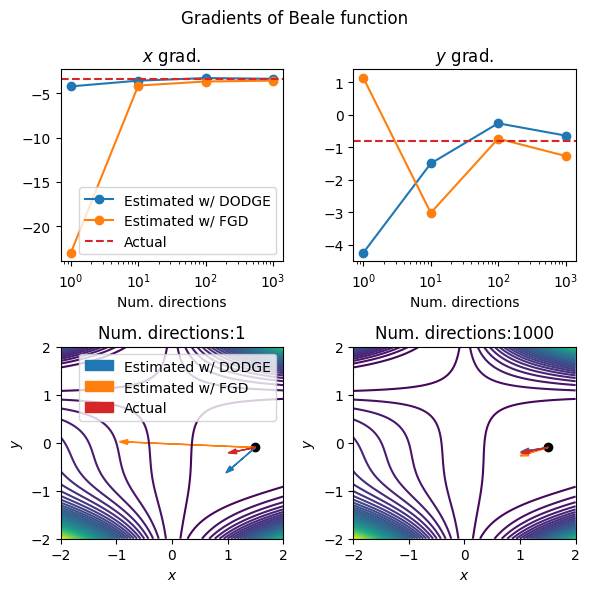

In [7]:
scale = 0.1
px, py = u.detach().numpy()
Xb = np.mgrid[-2:2:1000j, -2:2:1000j]
Zb = func(Xb)

titles = [r"$x$ grad.", r"$y$ grad."]; idx_dir = [0, -1]
plt.figure(figsize=(6, 6), dpi=100)
plt.suptitle("Gradients of Beale function")
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.title(titles[i])
    plt.semilogx(num_directions, estimated_grad_dodge[:, i], "o-", label="Estimated w/ DODGE")
    plt.semilogx(num_directions, estimated_grad_fgd[:, i], "o-", label="Estimated w/ FGD")
    plt.axhline(grad[i], linestyle="--", color="tab:red", label="Actual")
    plt.xlabel("Num. directions"); 
    if i == 0:
        plt.legend()

    plt.subplot(2,2,i+3)
    plt.title("Num. directions:"+str(num_directions[idx_dir[i]]))
    plt.contour(Xb[0], Xb[1], Zb, levels=50)
    plt.scatter(px, py, color="k")
    plt.arrow(px, py, estimated_grad_dodge[idx_dir[i], 0]*scale,  estimated_grad_dodge[idx_dir[i], 1]*scale, head_width=0.1, color='tab:blue', label="Estimated w/ DODGE")
    plt.arrow(px, py, estimated_grad_fgd[idx_dir[i], 0]*scale,  estimated_grad_fgd[idx_dir[i], 1]*scale, head_width=0.1, color='tab:orange', label="Estimated w/ FGD")
    plt.arrow(px, py, grad[0]*scale, grad[1]*scale, head_width=0.1, color='tab:red', label="Actual")
    plt.xlabel(r"$x$"); plt.ylabel(r"$y$") 
    if i == 0:
        plt.legend()
plt.tight_layout()

## Pytorchによる実装
ここから実装に入っていきます．MNISTデータセットをbackprop, DODGE, FGDで学習させます．このコードは[pytorch tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)を元に作成しました.

In [8]:
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cuda device


### 誤差逆伝播法による訓練
比較のため，勾配を正確に取得できる誤差逆伝播法を用いてモデルを訓練します．バッチサイズ64で15 epoch訓練します．

In [10]:
loss_fn = nn.CrossEntropyLoss()

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    loss_list = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            loss_list.append(loss)
    return np.array(loss_list)

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [13]:
model_bp = NeuralNetwork().to(device)
optimizer_bp = torch.optim.SGD(model_bp.parameters(), lr=1e-2)
train_loss_bp, test_loss_bp = [], []
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model_bp, loss_fn, optimizer_bp)
    test_loss = test(test_dataloader, model_bp, loss_fn)
    train_loss_bp.append(train_loss)
    test_loss_bp.append(test_loss)
train_loss_bp = np.concatenate(train_loss_bp)
test_loss_bp = np.array(test_loss_bp)

Epoch 1
-------------------------------
loss: 2.299546  [    0/60000]
loss: 2.243087  [ 6400/60000]
loss: 2.193906  [12800/60000]
loss: 1.990515  [19200/60000]
loss: 1.825056  [25600/60000]
loss: 1.497010  [32000/60000]
loss: 1.088965  [38400/60000]
loss: 1.071147  [44800/60000]
loss: 0.839060  [51200/60000]
loss: 0.702301  [57600/60000]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.645017 

Epoch 2
-------------------------------
loss: 0.738222  [    0/60000]
loss: 0.536721  [ 6400/60000]
loss: 0.543878  [12800/60000]
loss: 0.521499  [19200/60000]
loss: 0.463977  [25600/60000]
loss: 0.448645  [32000/60000]
loss: 0.326735  [38400/60000]
loss: 0.522257  [44800/60000]
loss: 0.468751  [51200/60000]
loss: 0.475883  [57600/60000]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.391872 

Epoch 3
-------------------------------
loss: 0.428448  [    0/60000]
loss: 0.321109  [ 6400/60000]
loss: 0.325715  [12800/60000]
loss: 0.404429  [19200/60000]
loss: 0.327921  [25600/60000]
loss: 0.372084  [32000/600

### 方向微分による訓練
同じ構造のモデルを2つ (`model`, `model_v`) 用意し，以下のような手順でパラメータを更新します．
1. `model`で順伝播を行い，`loss`を計算する．
2. 勾配の推定値を保存するDict`grad_estimate`を用意する．
3. 摂動`v`を生成する．この際，`model`のパラメータのkeyを辞書形式 `model.state_dict()`で取得し同じkeyで登録．同時に`model`と同じ構造の`model_v`のパラメータを`model`のパラメータに摂動`v`を加えたもので置換する．
4. `model_v`で順伝播を行い，`loss_v`を計算する．
5. 方向微分を`loss_v`と`loss`を用いて有限差分で計算する．
6. `grad_estimate`に勾配の推定値を加算する．
7. `num_direction`の数だけ3-6を繰り返す．
8. `grad_estimate`の値を`num_direction`で平均化し`torch.clamp()`でgradient clippingする (数値的に不安定なため)．
9. `optimizer.zero_grad()`で`model`のパラメータの勾配をzeroにする．
10. `param.grad`に推定した勾配値を代入する．
11. `optimizer.step()`でパラメータを更新する．

前節のシミュレーションでは`num_directions`を増やさないと推定された勾配が真の勾配に近づきませんでしたが，`num_directions=1`でも学習は進行します．もちろん増やしてもいいですが，計算量が増えます．また，学習率$lr$は0.001とbackpropの0.01よりも小さいものを用いていますが，これは`lr`を0.01にすると発散したためです．

In [14]:
def train_nograd(dataloader, model, model_v, loss_fn, optimizer, mode="dodge", num_directions=1, 
                 eps=1e-3, grad_clip=1):
    size = len(dataloader.dataset)
    loss_list = []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            pred = model(X) # prediction
            loss = loss_fn(pred, y) # loss
            grad_estimate = {} # Dict for estimated gradient
            for i in range(num_directions):
                v = {} # Dict for perturbation
                for param_v, key in zip(model_v.parameters(), model.state_dict()):
                    if mode == "dodge":
                        v[key] = 2*(torch.rand(model.state_dict()[key].shape).to(device) > 0.5) - 1 
                    elif mode == "fgd":
                        v[key] = torch.randn(model.state_dict()[key].shape).to(device)
                    else:
                        assert False, "mode is dodge or fgd"

                    param_v.data = model.state_dict()[key] + eps*v[key] # substitution with perturbated param.

                pred_v = model_v(X) # perturbated prediction
                loss_v = loss_fn(pred_v, y) # perturbated loss
                jvp = (loss_v - loss) / eps  # directional derivative of loss at point params in direction v
            
                # gradient estimation
                for key in model.state_dict():
                    if key in grad_estimate:
                        grad_estimate[key] += jvp * v[key]
                    else:
                        grad_estimate[key] = jvp * v[key]

            # averaging & gradient clipping for estimated gradient
            for key in model.state_dict():
                grad_estimate[key] = torch.clamp(grad_estimate[key]/num_directions, -grad_clip, grad_clip)

            optimizer.zero_grad()
            # replacement of loss.backward()
            for param, key in zip(model.parameters(), model.state_dict()):
                param.grad = grad_estimate[key]        
            optimizer.step()
            
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            loss_list.append(loss)
    return np.array(loss_list)

#### DODGE

In [15]:
model_dodge, model_dodgev = NeuralNetwork().to(device), NeuralNetwork().to(device)
for param in model_dodge.parameters():
    param.requires_grad = False
for param in model_dodgev.parameters():
    param.requires_grad = False
#optimizer = torch.optim.Adam(model_dodge.parameters(), lr=1e-3)
optimizer_dodge = torch.optim.SGD(model_dodge.parameters(), lr=1e-3)

train_loss_dodge, test_loss_dodge = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_nograd(train_dataloader, model_dodge, model_dodgev, loss_fn, optimizer_dodge, mode="dodge")
    test_loss = test(test_dataloader, model_dodge, loss_fn)
    train_loss_dodge.append(train_loss)
    test_loss_dodge.append(test_loss)
train_loss_dodge = np.concatenate(train_loss_dodge)
test_loss_dodge = np.array(test_loss_dodge)

Epoch 1
-------------------------------
loss: 2.293013  [    0/60000]
loss: 2.278605  [ 6400/60000]
loss: 2.305957  [12800/60000]
loss: 2.261985  [19200/60000]
loss: 2.278600  [25600/60000]
loss: 2.274848  [32000/60000]
loss: 2.264979  [38400/60000]
loss: 2.264772  [44800/60000]
loss: 2.243997  [51200/60000]
loss: 2.230047  [57600/60000]
Test Error: 
 Accuracy: 27.0%, Avg loss: 2.238401 

Epoch 2
-------------------------------
loss: 2.238425  [    0/60000]
loss: 2.213653  [ 6400/60000]
loss: 2.250131  [12800/60000]
loss: 2.172260  [19200/60000]
loss: 2.199060  [25600/60000]
loss: 2.191102  [32000/60000]
loss: 2.158249  [38400/60000]
loss: 2.203896  [44800/60000]
loss: 2.136338  [51200/60000]
loss: 2.109188  [57600/60000]
Test Error: 
 Accuracy: 51.2%, Avg loss: 2.119787 

Epoch 3
-------------------------------
loss: 2.115482  [    0/60000]
loss: 2.104982  [ 6400/60000]
loss: 2.143744  [12800/60000]
loss: 2.017807  [19200/60000]
loss: 2.061916  [25600/60000]
loss: 2.045247  [32000/600

#### FGD

In [16]:
model_fgd, model_fgdv = NeuralNetwork().to(device), NeuralNetwork().to(device)
for param in model_fgd.parameters():
    param.requires_grad = False
for param in model_fgdv.parameters():
    param.requires_grad = False
optimizer_fgd = torch.optim.SGD(model_fgd.parameters(), lr=1e-3)

train_loss_fgd, test_loss_fgd = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_nograd(train_dataloader, model_fgd, model_fgdv, loss_fn, optimizer_fgd, mode="fgd")
    test_loss = test(test_dataloader, model_fgd, loss_fn)
    train_loss_fgd.append(train_loss)
    test_loss_fgd.append(test_loss)
train_loss_fgd = np.concatenate(train_loss_fgd)
test_loss_fgd = np.array(test_loss_fgd)

Epoch 1
-------------------------------
loss: 2.296826  [    0/60000]
loss: 2.283787  [ 6400/60000]
loss: 2.293741  [12800/60000]
loss: 2.277387  [19200/60000]
loss: 2.291229  [25600/60000]
loss: 2.284855  [32000/60000]
loss: 2.269791  [38400/60000]
loss: 2.282986  [44800/60000]
loss: 2.260365  [51200/60000]
loss: 2.257126  [57600/60000]
Test Error: 
 Accuracy: 28.9%, Avg loss: 2.261620 

Epoch 2
-------------------------------
loss: 2.260387  [    0/60000]
loss: 2.243361  [ 6400/60000]
loss: 2.258446  [12800/60000]
loss: 2.217143  [19200/60000]
loss: 2.243744  [25600/60000]
loss: 2.238254  [32000/60000]
loss: 2.216753  [38400/60000]
loss: 2.238729  [44800/60000]
loss: 2.210622  [51200/60000]
loss: 2.196457  [57600/60000]
Test Error: 
 Accuracy: 31.1%, Avg loss: 2.202523 

Epoch 3
-------------------------------
loss: 2.204142  [    0/60000]
loss: 2.184506  [ 6400/60000]
loss: 2.217151  [12800/60000]
loss: 2.137058  [19200/60000]
loss: 2.168483  [25600/60000]
loss: 2.161743  [32000/600

### 学習則の比較
最後に各学習則の訓練誤差を比較してみましょう．

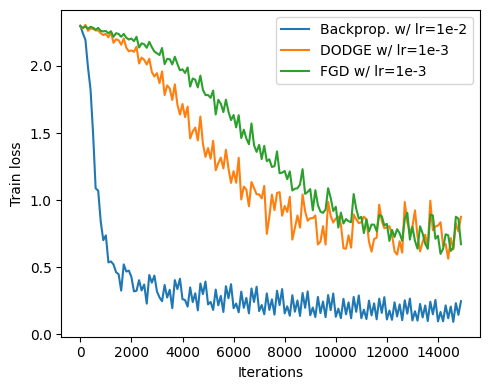

In [17]:
iterations = np.arange(len(train_loss_bp)) * 100
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(iterations, train_loss_bp, label="Backprop. w/ lr=1e-2")
plt.plot(iterations, train_loss_dodge, label="DODGE w/ lr=1e-3")
plt.plot(iterations, train_loss_fgd, label="FGD w/ lr=1e-3")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.legend()
plt.tight_layout()

学習初期の学習速度はDODGEの方が優れていましたが，最終的には同程度の損失・精度に収束しました．今回はPytorch自体のoptimizerを使用できるような実装にしましたが，Adamを用いてもテストデータに対する予測精度は変わりませんでした (～80%程度，確認にはoptimizaerの部分を変更してみてください)．`num_directions`を大きくすれば数値的に安定し，大きな学習率でも機能するかもしれません．あるいは学習率を下げて長い時間学習させればテストデータに対する予測精度は向上するかもしれません．いずれにせよ検証はしていないので興味がある方はやってみてください．DODGEもFGDも著者実装が公開されていないのですが，報告を読む限りはより効率的で安定した実装があるのかもしれません．